In [ ]:
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import os
import datetime

In [8]:
# Базовый путь к папке с данными
base_path = '../Data/Multilabel_CNN_data/'

# Загружаем массивы из папки Binary_CNN_data
X_train_cnn = np.load(f'{base_path}X_train_cnn.npy')
X_val_cnn = np.load(f'{base_path}X_val_cnn.npy')
X_test_cnn = np.load(f'{base_path}X_test_cnn.npy')

y_train = np.load(f'{base_path}y_train.npy')
y_val = np.load(f'{base_path}y_val.npy')
y_test = np.load(f'{base_path}y_test.npy')


МНОГОМЕТОЧНАЯ КЛАССИФИКАЦИЯ

Параметры модели:
Input shape: (25, 16, 1)
Number of classes: 5
Class names: ['hu', 'hg', 'hs', 'hm', 'hi']

СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛИ
✓ Модель создана и скомпилирована

Начало обучения...


Эпоха 50/50 - loss: 0.0653, val_loss: 0.0976, acc: 0.1902: 100%|██████████| 50/50 [00:24<00:00]


✓ Обучение завершено

ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ
Test Loss: 0.0994
Test Accuracy: 0.1797
Test Precision: 0.8866
Test Recall: 0.5150

Выполнение предсказаний...

МЕТРИКИ ПО КЛАССАМ

hu:
  Accuracy:  0.9771
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000
  Распределение: 0=598, 1=14

hg:
  Accuracy:  0.9935
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000
  Распределение: 0=608, 1=4

hs:
  Accuracy:  0.9559
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000
  Распределение: 0=585, 1=27

hm:
  Accuracy:  0.9706
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000
  Распределение: 0=594, 1=18

hi:
  Accuracy:  0.9526
  Precision: 0.8866
  Recall:    0.8269
  F1-score:  0.8557
  Распределение: 0=508, 1=104

ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ


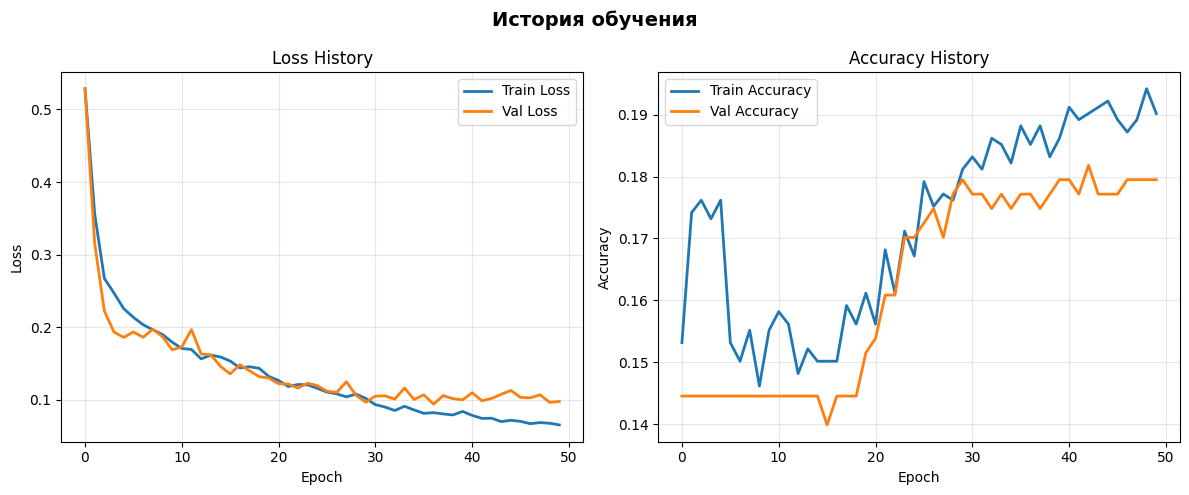

✓ График истории обучения показан


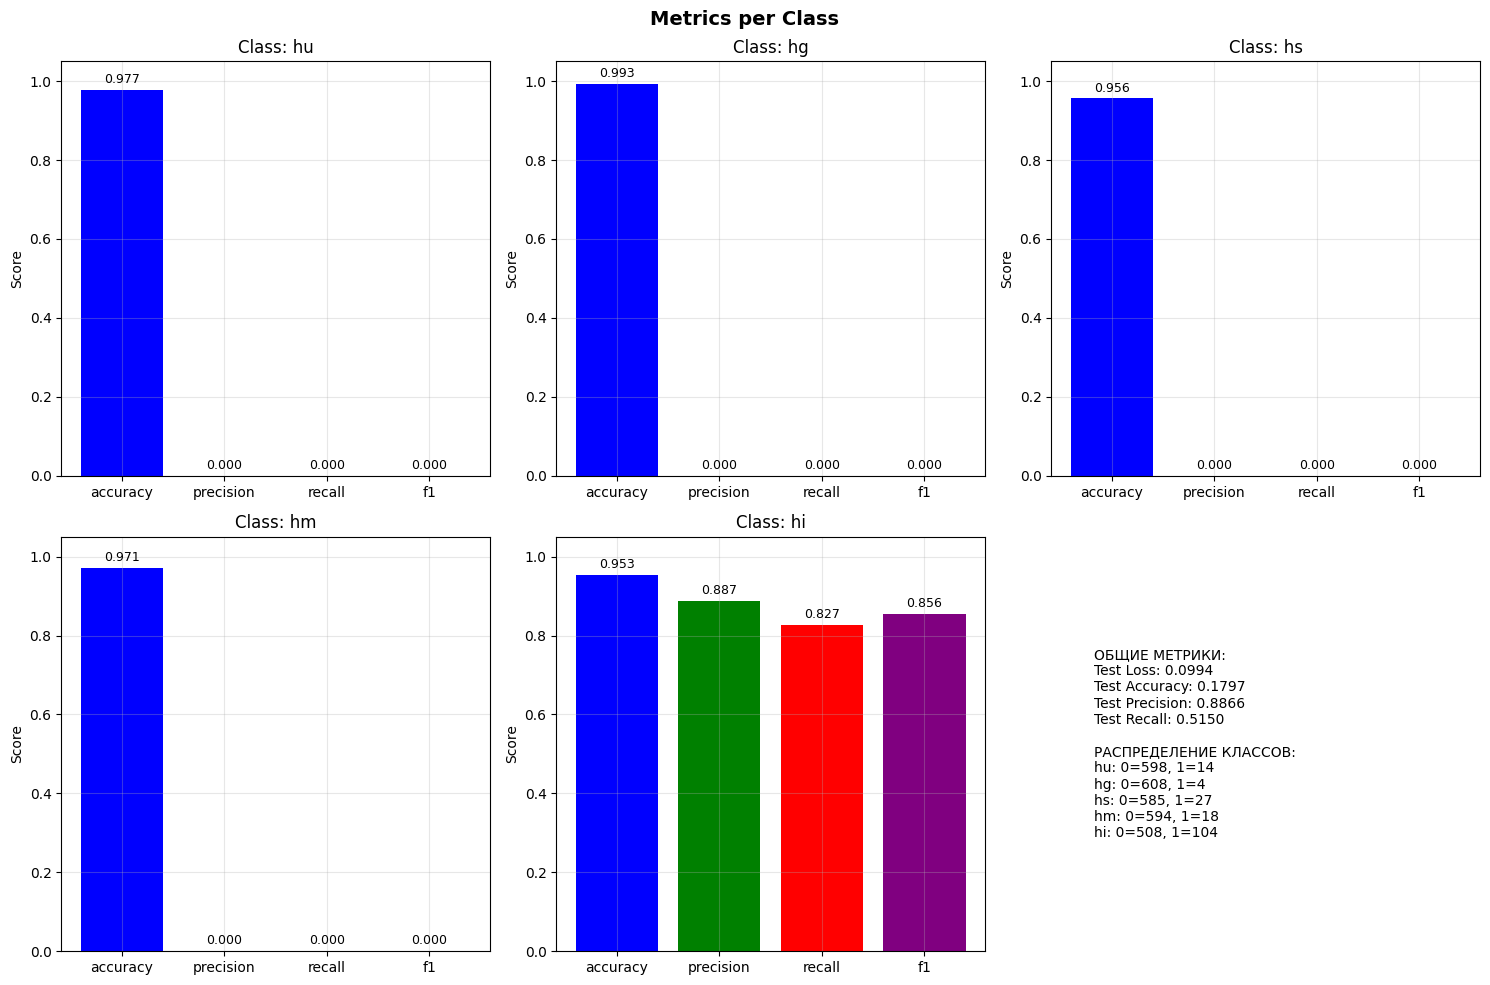

✓ Метрики по классам показаны


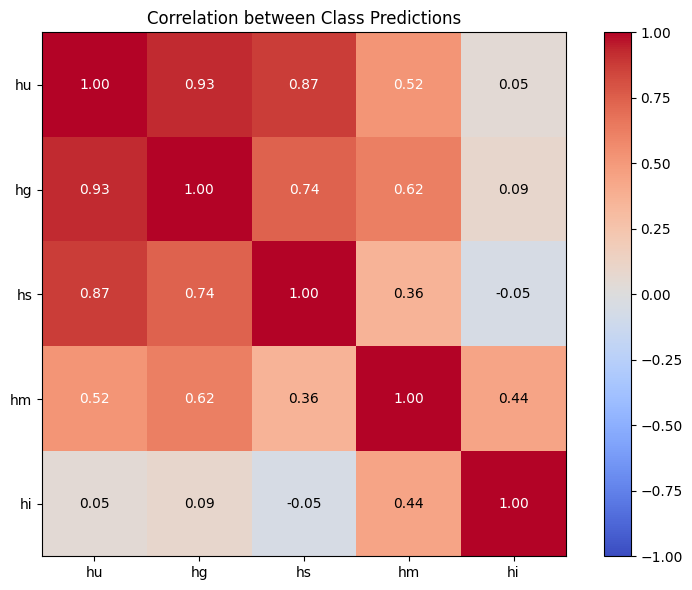

✓ Корреляция предсказаний показана

СОХРАНЕНИЕ РЕЗУЛЬТАТОВ В ФАЙЛЫ
✓ Извлекатель признаков сохранен
✓ История обучения сохранена
✓ Предсказания и метрики сохранены
✓ Графики сохранены в папку plots/
✓ Текстовая сводка сохранена

ВСЕ ФАЙЛЫ УСПЕШНО СОХРАНЕНЫ
Директория: ../Debugging_Information/Bests_Models/Multilabel/1_multilabel_classification/

СОХРАНЕННЫЕ ФАЙЛЫ:
✓ best_model.keras          Лучшая модель                  1,267,866 байт
✓ feature_extractor.keras   Извлекатель признаков          443,794 байт
✓ training_history.npy      История обучения               4,665 байт
✓ predictions_metrics.npy   Предсказания и метрики         50,068 байт
✓ experiment_summary.txt    Текстовая сводка               656 байт

ГРАФИКИ:
✓ training_history.png      261,821 байт
✓ per_class_metrics.png     281,917 байт
✓ predictions_correlation.png 144,156 байт

КРАТКАЯ СВОДКА РЕЗУЛЬТАТОВ:
Количество классов: 5
Общая Accuracy: 0.1797
Общий Loss: 0.0994

Лучший класс: hi (F1=0.8557)
Худший класс: hu (F1

In [12]:
# ============================================================================
# МНОГОМЕТОЧНАЯ КЛАССИФИКАЦИЯ - ОБУЧЕНИЕ И СОХРАНЕНИЕ
# ============================================================================

print("\n" + "="*60)
print("МНОГОМЕТОЧНАЯ КЛАССИФИКАЦИЯ")
print("="*60)

# Параметры модели
input_shape = X_train_cnn.shape[1:]
num_classes = 5
class_names = ['hu', 'hg', 'hs', 'hm', 'hi']

print(f"\nПараметры модели:")
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Создаем CNN для извлечения признаков
def create_cnn_feature_extractor(input_shape):
    model = models.Sequential(name="CNN_Feature_Extractor")
    
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape, name='conv1'))
    model.add(layers.BatchNormalization(name='bn1'))
    model.add(layers.MaxPooling2D((2, 2), name='pool1'))
    model.add(layers.Dropout(0.2, name='dropout1'))
    
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2'))
    model.add(layers.BatchNormalization(name='bn2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool2'))
    model.add(layers.Dropout(0.3, name='dropout2'))
    
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv3'))
    model.add(layers.BatchNormalization(name='bn3'))
    model.add(layers.GlobalAveragePooling2D(name='global_avg_pool'))
    
    model.add(layers.Dense(32, activation='relu', name='feature_dense1'))
    model.add(layers.Dropout(0.4, name='dropout3'))
    model.add(layers.Dense(5, activation=None, name='features'))
    
    return model

# Создаем полную модель
def create_full_multilabel_model(input_shape, num_classes):
    feature_extractor = create_cnn_feature_extractor(input_shape)
    
    classifier_head = models.Sequential([
        layers.Dense(16, activation='relu', name='classifier_dense1'),
        layers.Dropout(0.3, name='classifier_dropout1'),
        layers.Dense(8, activation='relu', name='classifier_dense2'),
        layers.Dense(num_classes, activation='sigmoid', name='output')
    ], name="Multilabel_Classifier_Head")
    
    inputs = layers.Input(shape=input_shape)
    features = feature_extractor(inputs)
    output = classifier_head(features)
    
    full_model = Model(inputs=inputs, outputs=output, name="CNN_Multilabel_Classifier")
    
    return full_model, feature_extractor

# Callback с прогресс-баром
class SingleProgressBarCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super().__init__()
        self.total_epochs = total_epochs
        self.current_epoch = 0
        self.pbar = None
        
    def on_train_begin(self, logs=None):
        self.pbar = tqdm(total=self.total_epochs, 
                        desc="Обучение", 
                        unit="эпоха",
                        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')
        
    def on_epoch_end(self, epoch, logs=None):
        self.current_epoch += 1
        metrics_str = f"Эпоха {self.current_epoch}/{self.total_epochs}"
        if logs:
            metrics_str += f" - loss: {logs.get('loss', 0):.4f}"
            metrics_str += f", val_loss: {logs.get('val_loss', 0):.4f}"
            metrics_str += f", acc: {logs.get('accuracy', 0):.4f}"
        self.pbar.set_description(metrics_str)
        self.pbar.update(1)
        
    def on_train_end(self, logs=None):
        self.pbar.close()

# ============================================================================
# ОБУЧЕНИЕ МОДЕЛИ
# ============================================================================

print(f"\n{'='*60}")
print("СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛИ")
print("="*60)

# Создаем модель
model, feature_extractor = create_full_multilabel_model(input_shape, num_classes)

# Компилируем
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(thresholds=0.5), tf.keras.metrics.Recall(thresholds=0.5)]
)

print("✓ Модель создана и скомпилирована")

# Настраиваем пути сохранения
model_save_dir = '../Debugging_Information/Bests_Models/Multilabel/1_multilabel_classification/'
os.makedirs(model_save_dir, exist_ok=True)
plots_dir = os.path.join(model_save_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

# Callbacks с сохранением в нужную директорию
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=0),
    ModelCheckpoint(os.path.join(model_save_dir, 'best_model.keras'), 
                   monitor='val_loss', save_best_only=True, verbose=0),
    SingleProgressBarCallback(total_epochs=50)
]

# Обучение
print("\nНачало обучения...")
history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=0
)
print("✓ Обучение завершено")

# ============================================================================
# ОЦЕНКА И ПРЕДСКАЗАНИЯ
# ============================================================================

print(f"\n{'='*60}")
print("ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ")
print("="*60)

# Оценка
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test_cnn, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Предсказания
print("\nВыполнение предсказаний...")
y_pred_proba = model.predict(X_test_cnn, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Метрики по классам
print(f"\n{'='*60}")
print("МЕТРИКИ ПО КЛАССАМ")
print("="*60)

label_metrics = {}
for i in range(num_classes):
    y_true_label = y_test[:, i]
    y_pred_label = y_pred[:, i]
    
    accuracy = (y_true_label == y_pred_label).mean()
    precision = (y_true_label[y_pred_label == 1] == 1).mean() if (y_pred_label == 1).sum() > 0 else 0
    recall = (y_pred_label[y_true_label == 1] == 1).mean() if (y_true_label == 1).sum() > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    label_metrics[class_names[i]] = {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'count_0': int((y_true_label == 0).sum()),
        'count_1': int((y_true_label == 1).sum())
    }
    
    print(f"\n{class_names[i]}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  Распределение: 0={label_metrics[class_names[i]]['count_0']}, 1={label_metrics[class_names[i]]['count_1']}")

# ============================================================================
# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ (ВЫВОД В БЛОКНОТ)
# ============================================================================

print(f"\n{'='*60}")
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*60)

# 1. История обучения
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss History')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax2.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy History')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('История обучения', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
print("✓ График истории обучения показан")

# 2. Метрики по классам
fig2, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, class_name in enumerate(class_names):
    if i < len(axes) - 1:
        metrics = label_metrics[class_name]
        metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
        values = [metrics[m] for m in metrics_to_plot]
        
        bars = axes[i].bar(metrics_to_plot, values, color=['blue', 'green', 'red', 'purple'])
        axes[i].set_title(f'Class: {class_name}')
        axes[i].set_ylabel('Score')
        axes[i].set_ylim([0, 1.05])
        axes[i].grid(True, alpha=0.3)
        
        for bar, value in zip(bars, values):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# Общая статистика
axes[-1].axis('off')
summary_text = f"""
ОБЩИЕ МЕТРИКИ:
Test Loss: {test_loss:.4f}
Test Accuracy: {test_acc:.4f}
Test Precision: {test_precision:.4f}
Test Recall: {test_recall:.4f}

РАСПРЕДЕЛЕНИЕ КЛАССОВ:
{chr(10).join(f'{class_names[i]}: 0={label_metrics[class_names[i]]["count_0"]}, 1={label_metrics[class_names[i]]["count_1"]}' for i in range(num_classes))}
"""
axes[-1].text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center')

plt.suptitle('Metrics per Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
print("✓ Метрики по классам показаны")

# 3. Корреляция предсказаний
fig3, ax = plt.subplots(figsize=(8, 6))
correlation_matrix = np.corrcoef(y_pred_proba.T)
im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
ax.set_title('Correlation between Class Predictions')

for i in range(num_classes):
    for j in range(num_classes):
        text = ax.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                      ha="center", va="center",
                      color="white" if abs(correlation_matrix[i, j]) > 0.5 else "black")

plt.colorbar(im)
plt.tight_layout()
plt.show()
print("✓ Корреляция предсказаний показана")

# ============================================================================
# СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
# ============================================================================

print(f"\n{'='*60}")
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ В ФАЙЛЫ")
print("="*60)

# 1. Сохраняем все компоненты модели
feature_extractor.save(os.path.join(model_save_dir, 'feature_extractor.keras'))
print(f"✓ Извлекатель признаков сохранен")

# 2. Сохраняем историю обучения
history_data = {
    'history': history.history,
    'input_shape': input_shape,
    'num_classes': num_classes,
    'class_names': class_names
}
np.save(os.path.join(model_save_dir, 'training_history.npy'), history_data)
print(f"✓ История обучения сохранена")

# 3. Сохраняем предсказания и метрики
predictions_data = {
    'y_test': y_test,
    'y_pred': y_pred,
    'y_pred_proba': y_pred_proba,
    'label_metrics': label_metrics,
    'overall_metrics': {
        'test_loss': float(test_loss),
        'test_accuracy': float(test_acc),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall)
    }
}
np.save(os.path.join(model_save_dir, 'predictions_metrics.npy'), predictions_data)
print(f"✓ Предсказания и метрики сохранены")

# 4. Сохраняем графики в файлы
fig1.savefig(os.path.join(plots_dir, 'training_history.png'), dpi=300, bbox_inches='tight')
fig2.savefig(os.path.join(plots_dir, 'per_class_metrics.png'), dpi=300, bbox_inches='tight')
fig3.savefig(os.path.join(plots_dir, 'predictions_correlation.png'), dpi=300, bbox_inches='tight')
print(f"✓ Графики сохранены в папку plots/")

# ============================================================================
# СОЗДАНИЕ СВОДКИ
# ============================================================================

# Текстовая сводка
summary_text = f"""
РЕЗУЛЬТАТЫ МНОГОМЕТОЧНОЙ КЛАССИФИКАЦИИ
=======================================

Дата: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Классы: {', '.join(class_names)}

ОБЩИЕ МЕТРИКИ:
Test Loss: {test_loss:.4f}
Test Accuracy: {test_acc:.4f}
Test Precision: {test_precision:.4f}
Test Recall: {test_recall:.4f}

МЕТРИКИ ПО КЛАССАМ:
{chr(10).join(f'{class_names[i]}: Acc={label_metrics[class_names[i]]["accuracy"]:.4f}, Prec={label_metrics[class_names[i]]["precision"]:.4f}, Rec={label_metrics[class_names[i]]["recall"]:.4f}, F1={label_metrics[class_names[i]]["f1"]:.4f}' for i in range(num_classes))}

ЛУЧШИЙ КЛАСС ПО F1: {max(class_names, key=lambda x: label_metrics[x]['f1'])}
ХУДШИЙ КЛАСС ПО F1: {min(class_names, key=lambda x: label_metrics[x]['f1'])}
"""

summary_path = os.path.join(model_save_dir, 'experiment_summary.txt')
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write(summary_text)
print(f"✓ Текстовая сводка сохранена")

# ============================================================================
# ФИНАЛЬНЫЙ ВЫВОД
# ============================================================================

print(f"\n{'='*60}")
print("ВСЕ ФАЙЛЫ УСПЕШНО СОХРАНЕНЫ")
print("="*60)
print(f"Директория: {model_save_dir}")

print(f"\nСОХРАНЕННЫЕ ФАЙЛЫ:")
files_list = [
    ('best_model.keras', 'Лучшая модель'),
    ('feature_extractor.keras', 'Извлекатель признаков'),
    ('training_history.npy', 'История обучения'),
    ('predictions_metrics.npy', 'Предсказания и метрики'),
    ('experiment_summary.txt', 'Текстовая сводка')
]

for filename, description in files_list:
    filepath = os.path.join(model_save_dir, filename)
    size = os.path.getsize(filepath) if os.path.exists(filepath) else 0
    print(f"✓ {filename:<25} {description:<30} {size:,} байт")

print(f"\nГРАФИКИ:")
plot_files = ['training_history.png', 'per_class_metrics.png', 'predictions_correlation.png']
for plot_file in plot_files:
    plot_path = os.path.join(plots_dir, plot_file)
    size = os.path.getsize(plot_path) if os.path.exists(plot_path) else 0
    print(f"✓ {plot_file:<25} {size:,} байт")

print(f"\n{'='*60}")
print("КРАТКАЯ СВОДКА РЕЗУЛЬТАТОВ:")
print("="*60)
print(f"Количество классов: {num_classes}")
print(f"Общая Accuracy: {test_acc:.4f}")
print(f"Общий Loss: {test_loss:.4f}")

best_class = max(class_names, key=lambda x: label_metrics[x]['f1'])
worst_class = min(class_names, key=lambda x: label_metrics[x]['f1'])
print(f"\nЛучший класс: {best_class} (F1={label_metrics[best_class]['f1']:.4f})")
print(f"Худший класс: {worst_class} (F1={label_metrics[worst_class]['f1']:.4f})")


МНОГОМЕТОЧНАЯ КЛАССИФИКАЦИЯ С УЧЕТОМ ДИСБАЛАНСА

Параметры модели:
Input shape: (25, 16, 1)
Number of classes: 5
Class names: ['hu', 'hg', 'hs', 'hm', 'hi']
Директория сохранения: ../Debugging_Information/Bests_Models/Multilabel/2_multilabel_classification_imbalanced/

АНАЛИЗ РАСПРЕДЕЛЕНИЯ КЛАССОВ
hu:
  Train: 22.0/999 (2.2%)
  Val:   9.0/429 (2.1%)
hg:
  Train: 8.0/999 (0.8%)
  Val:   3.0/429 (0.7%)
hs:
  Train: 44.0/999 (4.4%)
  Val:   19.0/429 (4.4%)
hm:
  Train: 29.0/999 (2.9%)
  Val:   13.0/429 (3.0%)
hi:
  Train: 169.0/999 (16.9%)
  Val:   72.0/429 (16.8%)
  Test:  104.0/612 (17.0%)
✓ Распределение классов сохранено

СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛИ

Веса классов:
hu: вес 0=0.02, вес 1=0.98
hg: вес 0=0.01, вес 1=0.99
hs: вес 0=0.04, вес 1=0.96
hm: вес 0=0.03, вес 1=0.97
hi: вес 0=0.17, вес 1=0.83

Начало обучения...
Epoch 1/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1424 - auc: 0.5849 - f1_score: 0.1657 - loss: 0.3406
Epoch 1: val_f1_score improved from None to 0.00000,

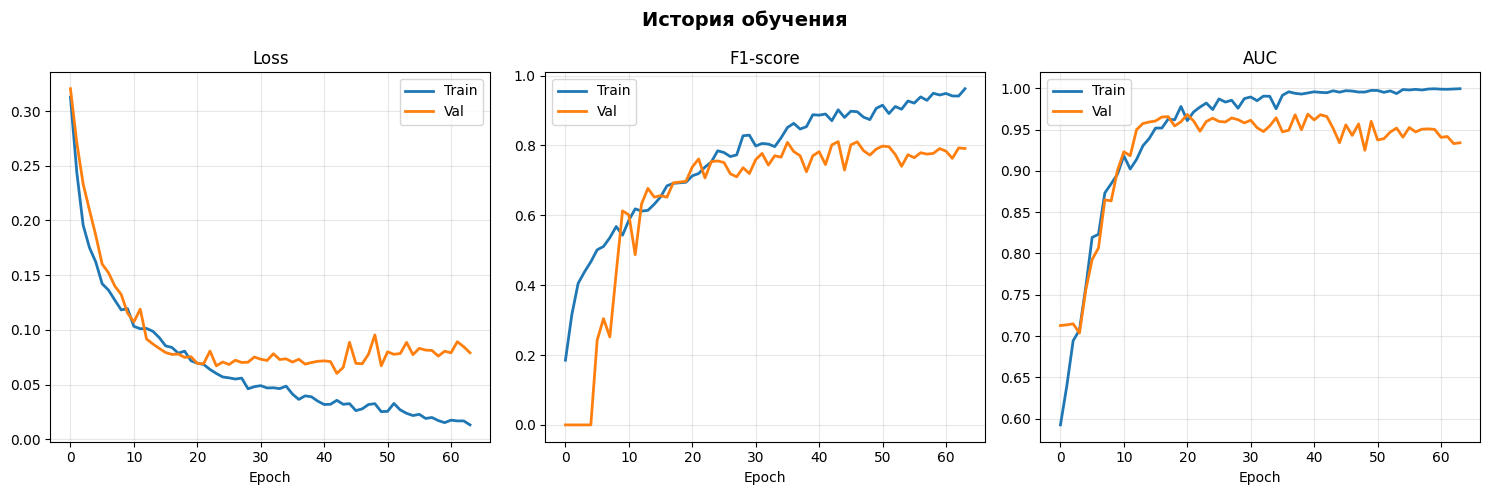

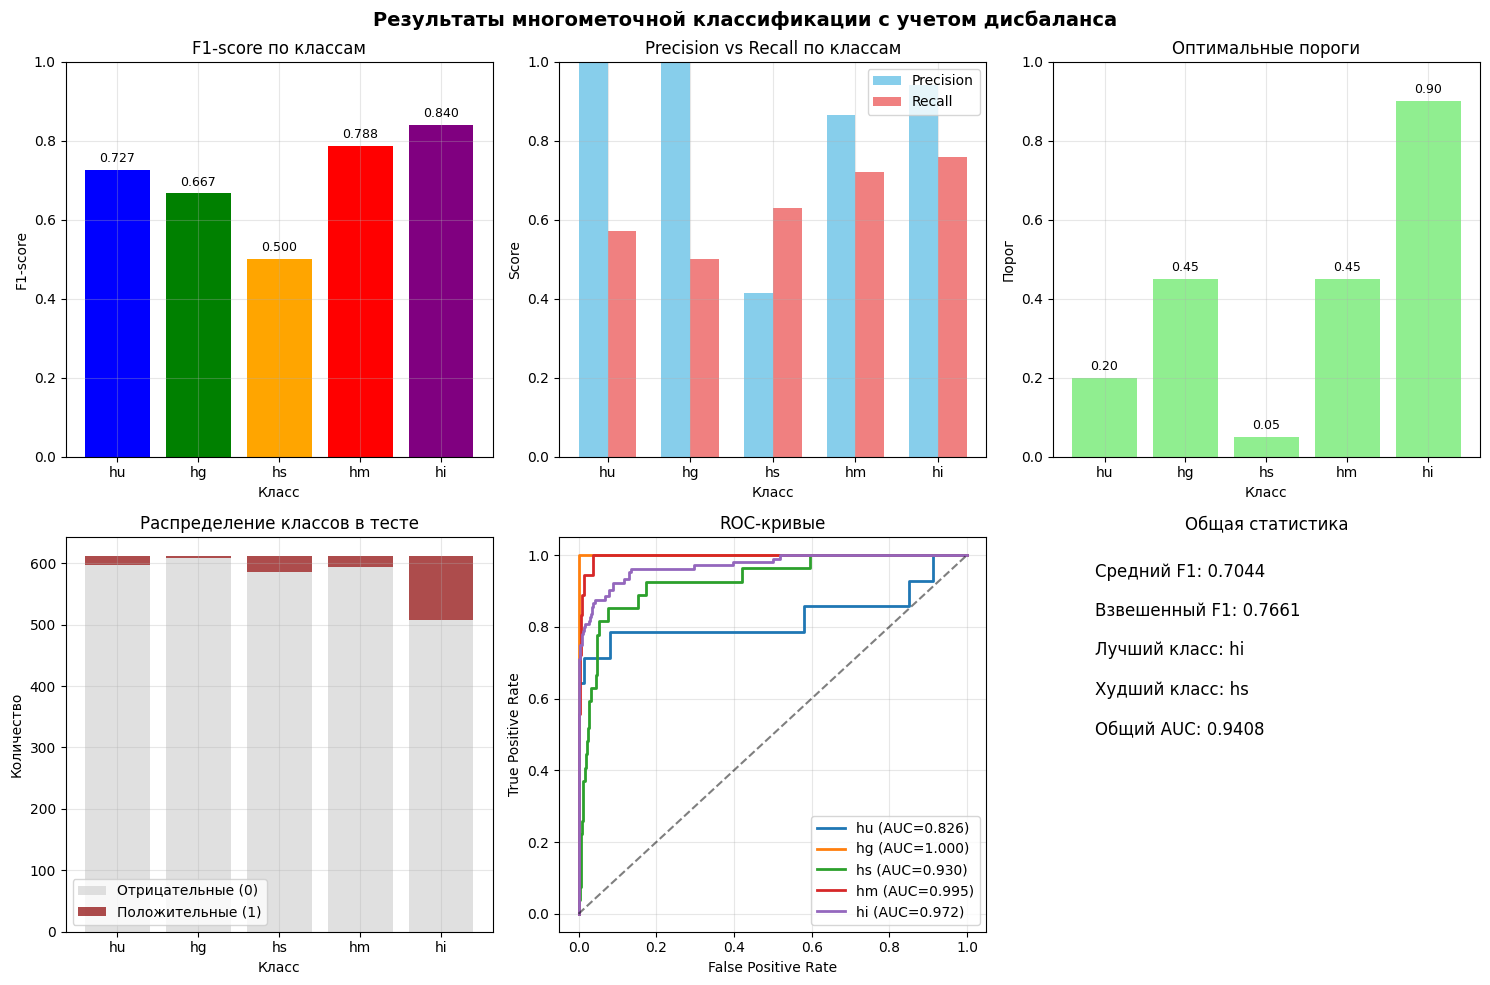


Сохранение графиков...
✓ Графики сохранены в папку plots/

ФИНАЛЬНАЯ СВОДКА РЕЗУЛЬТАТОВ
✓ Текстовая сводка сохранена

ВСЕ ФАЙЛЫ УСПЕШНО СОХРАНЕНЫ
Директория: ../Debugging_Information/Bests_Models/Multilabel/2_multilabel_classification_imbalanced/

ОСНОВНЫЕ ФАЙЛЫ:
✓ best_model.keras          Лучшая модель                       1,248,730 байт
✓ training_history.npy      История обучения                    5,649 байт
✓ class_distribution.npy    Распределение классов               635 байт
✓ optimal_thresholds.npy    Оптимальные пороги                  168 байт
✓ results_summary.npy       Результаты по классам               1,945 байт
✓ predictions.npy           Предсказания                        49,501 байт
✓ experiment_summary.txt    Текстовая сводка                    1,156 байт

ГРАФИКИ:
✓ training_history.png      313,090 байт
✓ results_analysis.png      437,644 байт
✓ additional_analysis.png   135,157 байт

КРАТКАЯ СВОДКА РЕЗУЛЬТАТОВ:
Средний F1-score: 0.7044
Общий AUC: 0.9408
Лучш

In [13]:
# ============================================================================
# МНОГОМЕТОЧНАЯ КЛАССИФИКАЦИЯ С УЧЕТОМ ДИСБАЛАНСА - ОБУЧЕНИЕ И СОХРАНЕНИЕ
# ============================================================================

print("\n" + "="*60)
print("МНОГОМЕТОЧНАЯ КЛАССИФИКАЦИЯ С УЧЕТОМ ДИСБАЛАНСА")
print("="*60)

# Параметры модели
input_shape = X_train_cnn.shape[1:]
num_classes = 5
class_names = ['hu', 'hg', 'hs', 'hm', 'hi']

print(f"\nПараметры модели:")
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Настраиваем пути сохранения
model_save_dir = '../Debugging_Information/Bests_Models/Multilabel/2_multilabel_classification_imbalanced/'
os.makedirs(model_save_dir, exist_ok=True)
plots_dir = os.path.join(model_save_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

print(f"Директория сохранения: {model_save_dir}")

# ==================== АНАЛИЗ ДИСБАЛАНСА ====================
print("\n" + "="*50)
print("АНАЛИЗ РАСПРЕДЕЛЕНИЯ КЛАССОВ")
print("="*50)

class_distribution = {}
for i, name in enumerate(class_names):
    pos_count_train = y_train[:, i].sum()
    pos_count_val = y_val[:, i].sum()
    pos_count_test = y_test[:, i].sum()
    
    class_distribution[name] = {
        'train': {'pos': int(pos_count_train), 'neg': int(len(y_train) - pos_count_train)},
        'val': {'pos': int(pos_count_val), 'neg': int(len(y_val) - pos_count_val)},
        'test': {'pos': int(pos_count_test), 'neg': int(len(y_test) - pos_count_test)}
    }
    
    print(f"{name}:")
    print(f"  Train: {pos_count_train}/{len(y_train)} ({pos_count_train/len(y_train)*100:.1f}%)")
    print(f"  Val:   {pos_count_val}/{len(y_val)} ({pos_count_val/len(y_val)*100:.1f}%)")
print(f"  Test:  {pos_count_test}/{len(y_test)} ({pos_count_test/len(y_test)*100:.1f}%)")

# Сохраняем распределение классов
np.save(os.path.join(model_save_dir, 'class_distribution.npy'), class_distribution)
print(f"✓ Распределение классов сохранено")

# ==================== КАСТОМНАЯ ФУНКЦИЯ ПОТЕРЬ ====================
def weighted_binary_crossentropy(y_true, y_pred):
    pos_weight = 10.0
    neg_weight = 1.0
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    weights = y_true * pos_weight + (1 - y_true) * neg_weight
    weighted_bce = bce * weights
    return tf.reduce_mean(weighted_bce)

def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        epsilon = 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        focal_loss = alpha_t * (1 - p_t) ** gamma * cross_entropy
        return tf.reduce_mean(focal_loss)
    return loss

# ==================== F1-SCORE МЕТРИКА ====================
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision(thresholds=threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=threshold)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + 1e-7))
    
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# ==================== МОДЕЛЬ С УЧЕТОМ ДИСБАЛАНСА ====================
def create_simple_multilabel_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(5, activation=None)(x)
    
    outputs = layers.Dense(
        num_classes, 
        activation='sigmoid',
        kernel_initializer='glorot_normal',
        bias_initializer=tf.keras.initializers.Constant(-1.0)
    )(x)
    
    return Model(inputs=inputs, outputs=outputs)

# ==================== ОБУЧЕНИЕ МОДЕЛИ ====================
print(f"\n{'='*60}")
print("СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛИ")
print("="*60)

model = create_simple_multilabel_model(input_shape, num_classes)
optimizer = Adam(learning_rate=0.001)

# Вычисляем веса классов
class_weights = {}
print("\nВеса классов:")
for i in range(num_classes):
    pos_samples = y_train[:, i].sum()
    neg_samples = len(y_train) - pos_samples
    
    weight_for_class_1 = (1 / pos_samples) * (len(y_train) / 2.0) if pos_samples > 0 else 1.0
    weight_for_class_0 = (1 / neg_samples) * (len(y_train) / 2.0)
    
    total = weight_for_class_0 + weight_for_class_1
    weight_for_class_0 /= total
    weight_for_class_1 /= total
    
    class_weights[i] = {0: weight_for_class_0, 1: weight_for_class_1}
    print(f"{class_names[i]}: вес 0={weight_for_class_0:.2f}, вес 1={weight_for_class_1:.2f}")

def simple_weighted_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_mean(bce)

model.compile(
    optimizer=optimizer,
    loss=simple_weighted_loss,
    metrics=['accuracy', F1Score(threshold=0.5, name='f1_score'), 
             tf.keras.metrics.AUC(multi_label=True, name='auc')]
)

# Callbacks с сохранением в нужную директорию
callbacks = [
    EarlyStopping(monitor='val_f1_score', patience=20, restore_best_weights=True, verbose=1, mode='max'),
    ReduceLROnPlateau(monitor='val_f1_score', factor=0.5, patience=10, min_lr=1e-6, verbose=1, mode='max'),
    ModelCheckpoint(os.path.join(model_save_dir, 'best_model.keras'), 
                   monitor='val_f1_score', save_best_only=True, verbose=1, mode='max')
]

# Обучение
print("\nНачало обучения...")
history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)
print("✓ Обучение завершено")

# Сохраняем историю обучения
np.save(os.path.join(model_save_dir, 'training_history.npy'), history.history)

# ==================== ОЦЕНКА МОДЕЛИ ====================
print(f"\n{'='*60}")
print("ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ")
print("="*60)

# Оценка со стандартным порогом 0.5
test_results = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"\nСтандартный порог (0.5):")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
print(f"F1-score: {test_results[2]:.4f}")
print(f"AUC: {test_results[3]:.4f}")

# ==================== ПОДБОР ОПТИМАЛЬНЫХ ПОРОГОВ ====================
print(f"\n{'='*60}")
print("ПОДБОР ОПТИМАЛЬНЫХ ПОРОГОВ")
print("="*60)

def find_optimal_thresholds(model, X_val, y_val, class_names):
    y_pred_proba = model.predict(X_val, verbose=0)
    thresholds = []
    
    for i in range(len(class_names)):
        y_true = y_val[:, i]
        y_prob = y_pred_proba[:, i]
        
        best_threshold = 0.5
        best_f1 = 0
        
        for threshold in np.arange(0.05, 0.95, 0.05):
            y_pred = (y_prob > threshold).astype(int)
            tp = np.sum((y_true == 1) & (y_pred == 1))
            fp = np.sum((y_true == 0) & (y_pred == 1))
            fn = np.sum((y_true == 1) & (y_pred == 0))
            
            if tp + fp > 0 and tp + fn > 0:
                precision = tp / (tp + fp)
                recall = tp / (tp + fn)
                f1 = 2 * precision * recall / (precision + recall)
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
        
        thresholds.append(best_threshold)
        print(f"{class_names[i]}: порог={best_threshold:.2f}, F1={best_f1:.4f}")
    
    return thresholds

optimal_thresholds = find_optimal_thresholds(model, X_val_cnn, y_val, class_names)
np.save(os.path.join(model_save_dir, 'optimal_thresholds.npy'), optimal_thresholds)

# ==================== ОЦЕНКА С ОПТИМАЛЬНЫМИ ПОРОГАМИ ====================
print(f"\n{'='*60}")
print("ОЦЕНКА С ОПТИМАЛЬНЫМИ ПОРОГАМИ")
print("="*60)

y_pred_proba = model.predict(X_test_cnn, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int)

results_summary = []
for i, name in enumerate(class_names):
    threshold = optimal_thresholds[i]
    y_true = y_test[:, i]
    y_pred_opt = (y_pred_proba[:, i] > threshold).astype(int)
    
    tp = np.sum((y_true == 1) & (y_pred_opt == 1))
    fp = np.sum((y_true == 0) & (y_pred_opt == 1))
    fn = np.sum((y_true == 1) & (y_pred_opt == 0))
    tn = np.sum((y_true == 0) & (y_pred_opt == 0))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    
    results_summary.append({
        'name': name,
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
        'pos_count': y_true.sum(),
        'neg_count': len(y_true) - y_true.sum()
    })
    
    print(f"\n{name} (порог={threshold:.2f}):")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Положительных: {y_true.sum()}/{len(y_true)}")

# Сохраняем результаты
np.save(os.path.join(model_save_dir, 'results_summary.npy'), results_summary)
np.save(os.path.join(model_save_dir, 'predictions.npy'), {
    'y_pred_proba': y_pred_proba,
    'y_pred': y_pred,
    'y_test': y_test
})

# ==================== ВИЗУАЛИЗАЦИЯ В БЛОКНОТЕ ====================
print(f"\n{'='*60}")
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*60)

# 1. История обучения
fig1, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(history.history['loss'], label='Train', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val', linewidth=2)
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['f1_score'], label='Train', linewidth=2)
axes[1].plot(history.history['val_f1_score'], label='Val', linewidth=2)
axes[1].set_title('F1-score')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(history.history['auc'], label='Train', linewidth=2)
axes[2].plot(history.history['val_auc'], label='Val', linewidth=2)
axes[2].set_title('AUC')
axes[2].set_xlabel('Epoch')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('История обучения', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Детальные результаты
fig2, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# F1-score по классам
f1_scores = [r['f1'] for r in results_summary]
class_labels = [r['name'] for r in results_summary]

axes[0].bar(class_labels, f1_scores, color=['blue', 'green', 'orange', 'red', 'purple'])
axes[0].set_title('F1-score по классам')
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('F1-score')
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3)
for i, v in enumerate(f1_scores):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

# Precision vs Recall
precision_scores = [r['precision'] for r in results_summary]
recall_scores = [r['recall'] for r in results_summary]

x = np.arange(len(class_labels))
width = 0.35
axes[1].bar(x - width/2, precision_scores, width, label='Precision', color='skyblue')
axes[1].bar(x + width/2, recall_scores, width, label='Recall', color='lightcoral')
axes[1].set_title('Precision vs Recall по классам')
axes[1].set_xlabel('Класс')
axes[1].set_ylabel('Score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_labels)
axes[1].legend()
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3)

# Оптимальные пороги
thresholds = [r['threshold'] for r in results_summary]
axes[2].bar(class_labels, thresholds, color='lightgreen')
axes[2].set_title('Оптимальные пороги')
axes[2].set_xlabel('Класс')
axes[2].set_ylabel('Порог')
axes[2].set_ylim(0, 1)
axes[2].grid(True, alpha=0.3)
for i, v in enumerate(thresholds):
    axes[2].text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=9)

# Распределение классов
pos_counts = [r['pos_count'] for r in results_summary]
neg_counts = [r['neg_count'] for r in results_summary]

axes[3].bar(class_labels, neg_counts, label='Отрицательные (0)', color='lightgray', alpha=0.7)
axes[3].bar(class_labels, pos_counts, bottom=neg_counts, label='Положительные (1)', color='darkred', alpha=0.7)
axes[3].set_title('Распределение классов в тесте')
axes[3].set_xlabel('Класс')
axes[3].set_ylabel('Количество')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

# ROC-кривые
from sklearn.metrics import roc_curve, auc

axes[4].set_title('ROC-кривые')
for i, name in enumerate(class_names):
    y_true = y_test[:, i]
    y_prob = y_pred_proba[:, i]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    axes[4].plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})', linewidth=2)

axes[4].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[4].set_xlabel('False Positive Rate')
axes[4].set_ylabel('True Positive Rate')
axes[4].legend(loc='lower right')
axes[4].grid(True, alpha=0.3)

# Общая статистика
avg_f1 = np.mean(f1_scores)
weighted_f1 = np.average(f1_scores, weights=pos_counts)

axes[5].text(0.1, 0.9, f'Средний F1: {avg_f1:.4f}', fontsize=12)
axes[5].text(0.1, 0.8, f'Взвешенный F1: {weighted_f1:.4f}', fontsize=12)
axes[5].text(0.1, 0.7, f'Лучший класс: {class_labels[np.argmax(f1_scores)]}', fontsize=12)
axes[5].text(0.1, 0.6, f'Худший класс: {class_labels[np.argmin(f1_scores)]}', fontsize=12)
axes[5].text(0.1, 0.5, f'Общий AUC: {test_results[3]:.4f}', fontsize=12)
axes[5].axis('off')
axes[5].set_title('Общая статистика')

plt.suptitle('Результаты многометочной классификации с учетом дисбаланса', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ==================== СОХРАНЕНИЕ ГРАФИКОВ ====================
print(f"\nСохранение графиков...")

fig1.savefig(os.path.join(plots_dir, 'training_history.png'), dpi=300, bbox_inches='tight')
fig2.savefig(os.path.join(plots_dir, 'results_analysis.png'), dpi=300, bbox_inches='tight')

# 3. Дополнительные графики
fig3, axes = plt.subplots(1, 2, figsize=(12, 5))

# Сравнение распределения классов
train_pos = [class_distribution[name]['train']['pos'] for name in class_names]
test_pos = [class_distribution[name]['test']['pos'] for name in class_names]

x = np.arange(len(class_labels))
width = 0.35
axes[0].bar(x - width/2, train_pos, width, label='Train', color='skyblue')
axes[0].bar(x + width/2, test_pos, width, label='Test', color='lightcoral')
axes[0].set_title('Положительные примеры по классам')
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('Количество')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_labels)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Конфузии (FP vs FN)
fp_counts = [r['fp'] for r in results_summary]
fn_counts = [r['fn'] for r in results_summary]

axes[1].bar(class_labels, fp_counts, label='False Positive', color='orange', alpha=0.7)
axes[1].bar(class_labels, fn_counts, bottom=fp_counts, label='False Negative', color='red', alpha=0.7)
axes[1].set_title('Ошибки предсказания (FP/FN)')
axes[1].set_xlabel('Класс')
axes[1].set_ylabel('Количество ошибок')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'additional_analysis.png'), dpi=300, bbox_inches='tight')
plt.close()

print(f"✓ Графики сохранены в папку plots/")

# ==================== ФИНАЛЬНАЯ СВОДКА ====================
print(f"\n{'='*60}")
print("ФИНАЛЬНАЯ СВОДКА РЕЗУЛЬТАТОВ")
print("="*60)

avg_f1 = np.mean([r['f1'] for r in results_summary])
best_val_f1 = max(history.history['val_f1_score'])
best_epoch = np.argmax(history.history['val_f1_score']) + 1

summary_text = f"""
РЕЗУЛЬТАТЫ МНОГОМЕТОЧНОЙ КЛАССИФИКАЦИИ С УЧЕТОМ ДИСБАЛАНСА
============================================================

Дата: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Классы: {', '.join(class_names)}

ОБУЧЕНИЕ:
---------
Лучшая эпоха: {best_epoch}
Лучший val F1-score: {best_val_f1:.4f}
Эпох обучения: {len(history.history['loss'])}

ОБЩИЕ РЕЗУЛЬТАТЫ (порог=0.5):
-----------------------------
Loss: {test_results[0]:.4f}
Accuracy: {test_results[1]:.4f}
F1-score: {test_results[2]:.4f}
AUC: {test_results[3]:.4f}

РЕЗУЛЬТАТЫ С ОПТИМАЛЬНЫМИ ПОРОГАМИ:
----------------------------------
Средний F1-score: {avg_f1:.4f}
Оптимальные пороги: {', '.join(f'{t:.2f}' for t in thresholds)}

МЕТРИКИ ПО КЛАССАМ:
------------------
{chr(10).join(f'{r["name"]}: F1={r["f1"]:.4f}, Prec={r["precision"]:.4f}, Rec={r["recall"]:.4f}, Порог={r["threshold"]:.2f}' for r in results_summary)}

РЕКОМЕНДАЦИИ:
------------
Лучший класс: {class_labels[np.argmax(f1_scores)]} (F1={max(f1_scores):.4f})
Худший класс: {class_labels[np.argmin(f1_scores)]} (F1={min(f1_scores):.4f})
"""

summary_path = os.path.join(model_save_dir, 'experiment_summary.txt')
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write(summary_text)
print(f"✓ Текстовая сводка сохранена")

# ==================== ФИНАЛЬНЫЙ ВЫВОД ====================
print(f"\n{'='*60}")
print("ВСЕ ФАЙЛЫ УСПЕШНО СОХРАНЕНЫ")
print("="*60)
print(f"Директория: {model_save_dir}")

print(f"\nОСНОВНЫЕ ФАЙЛЫ:")
files_list = [
    ('best_model.keras', 'Лучшая модель'),
    ('training_history.npy', 'История обучения'),
    ('class_distribution.npy', 'Распределение классов'),
    ('optimal_thresholds.npy', 'Оптимальные пороги'),
    ('results_summary.npy', 'Результаты по классам'),
    ('predictions.npy', 'Предсказания'),
    ('experiment_summary.txt', 'Текстовая сводка')
]

for filename, description in files_list:
    filepath = os.path.join(model_save_dir, filename)
    if os.path.exists(filepath):
        size = os.path.getsize(filepath)
        print(f"✓ {filename:<25} {description:<35} {size:,} байт")

print(f"\nГРАФИКИ:")
plot_files = ['training_history.png', 'results_analysis.png', 'additional_analysis.png']
for plot_file in plot_files:
    plot_path = os.path.join(plots_dir, plot_file)
    if os.path.exists(plot_path):
        size = os.path.getsize(plot_path)
        print(f"✓ {plot_file:<25} {size:,} байт")

print(f"\n{'='*60}")
print("КРАТКАЯ СВОДКА РЕЗУЛЬТАТОВ:")
print("="*60)
print(f"Средний F1-score: {avg_f1:.4f}")
print(f"Общий AUC: {test_results[3]:.4f}")
print(f"Лучший класс: {class_labels[np.argmax(f1_scores)]} (F1={max(f1_scores):.4f})")
print(f"Худший класс: {class_labels[np.argmin(f1_scores)]} (F1={min(f1_scores):.4f})")
print(f"Оптимальные пороги: {', '.join(f'{t:.2f}' for t in thresholds)}")